##Image Classification For Teeth


## Import Libraries

In [1]:
from keras.models import Sequential,load_model,Model
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D
from keras.layers import  Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Input,GlobalAveragePooling2D
import seaborn as sns
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import  os ,glob ,random,cv2
from tqdm import tqdm
from PIL import Image
import pandas as pd


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Define Constants

In [3]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

##Read Data from Google Drive

In [4]:
!unzip '/content/drive/MyDrive/Teeth_New.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Teeth_NewDataset/Testing/CoS/b_143_0_7662.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_144_0_3192.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_145_0_9171.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_146_0_3336.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_146_0_8825.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_146_0_9344.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_149_0_2027.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_149_0_2197.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_150_0_1613.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_150_0_2905.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_151_0_4334.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_152_0_1106.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_152_0_5845.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_152_0_6845.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/b_79.jpg  
  inflating: Teeth_NewDataset/Testing/CoS/

##Preprocessing Data

In [5]:
train_data = '/content/Teeth_NewDataset/Training'
test_data = '/content/Teeth_NewDataset/Testing'
valid_data = '/content/Teeth_NewDataset/Validation'

In [6]:
# calculating various statistics related to the number of image files in multiple folders
num_files = [len(glob.glob(f"{train_data}/{folder}/*.jpg")) for folder in os.listdir(train_data)]
max_files = max(num_files)
min_files = min(num_files)

print(f"Maximum number of files in a folder: {max_files}")
print(f"Minimum number of files in a folder: {min_files}")


Maximum number of files in a folder: 660
Minimum number of files in a folder: 396


In [7]:
# counting the total number of image files in multiple folders in train data
total_images = 0
for folder in  os.listdir(train_data) :
    files = glob.glob(f"{train_data}/{folder}/*.jpg")
    total_images += len(files)
    print(f'For training data , found {len(files)} in folder {folder}')

print(f'Total number of images: {total_images} ')

For training data , found 587 in folder CaS
For training data , found 440 in folder Gum
For training data , found 480 in folder OT
For training data , found 396 in folder OC
For training data , found 660 in folder OLP
For training data , found 660 in folder MC
For training data , found 550 in folder CoS
Total number of images: 3773 


In [8]:
# counting the total number of image files in multiple folders in valid data
total_images = 0
for folder in  os.listdir(valid_data) :
    files = glob.glob(f"{valid_data}/{folder}/*.jpg")
    total_images += len(files)
    print(f'For training data , found {len(files)} in folder {folder}')

print(f'Total number of images: {total_images} ')

For training data , found 107 in folder CaS
For training data , found 80 in folder Gum
For training data , found 87 in folder OT
For training data , found 72 in folder OC
For training data , found 120 in folder OLP
For training data , found 120 in folder MC
For training data , found 99 in folder CoS
Total number of images: 685 


In [9]:
# check size for all image in data train
# AllSize = []
# for i in tqdm(os.listdir(train_data)):
#     for j in os.listdir(train_data+'/'+i):
#         img = cv2.imread(train_data+'/'+i+'/'+j)
#         AllSize.append(img.shape)

# set(AllSize)

In [10]:
# check size for all image in data train
# AllSize = []
# for i in tqdm(os.listdir(valid_data)):
#     for j in os.listdir(valid_data+'/'+i):
#         img = cv2.imread(valid_data+'/'+i+'/'+j)
#         AllSize.append(img.shape)

# set(AllSize)

In [11]:
# Get the names of classes (subfolders) and print the result
train_data = "/content/Teeth_NewDataset/Training"


class_names = [folder_name for folder_name in os.listdir(train_data) if os.path.isdir(os.path.join(train_data, folder_name))]

print(list(class_names))

['CaS', 'Gum', 'OT', 'OC', 'OLP', 'MC', 'CoS']


In [12]:
# class_names = ['MC', 'CaS', 'Gum', 'OC', 'OLP', 'OT', 'CoS']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}


nb_classes = len(class_names)


class_names_label

{'CaS': 0, 'Gum': 1, 'OT': 2, 'OC': 3, 'OLP': 4, 'MC': 5, 'CoS': 6}

In [14]:
# القاموس الخاص بالكلاسات
class_names = {'CaS': 0, 'Gum': 1, 'OT': 2, 'OC': 3, 'OLP': 4, 'MC': 5, 'CoS': 6}

# اسم الملف الذي سيتم حفظ القاموس فيه
file_name = 'class_names.txt'

# حفظ القاموس في ملف نصي
with open(file_name, 'w') as file:
    for key, value in class_names.items():
        file.write(f"{key}: {value}\n")

print(f"تم حفظ الكلاسات في الملف {file_name}")


تم حفظ الكلاسات في الملف class_names.txt


In [15]:
# Make Data Frame with number of classes for train folders

rows = []

for folder in os.listdir(train_data):
    path = os.path.join(train_data, folder, '*.jpg')
    image_paths = glob.glob(path)
    for image_path in image_paths:
        # احصل على التصنيف الرقمي من القاموس باستخدام اسم المجلد
        category = class_names_label.get(folder, 'unknown')  # استخدم 'unknown' إذا كان اسم المجلد غير موجود
        rows.append({'path': image_path, 'category': category})

df_train = pd.DataFrame(rows)


In [16]:
# Make Data Frame with number of classes for valid folders

rows = []

for folder in os.listdir(valid_data):
    path = os.path.join(valid_data, folder, '*.jpg')
    image_paths = glob.glob(path)
    for image_path in image_paths:
        # احصل على التصنيف الرقمي من القاموس باستخدام اسم المجلد
        category = class_names_label.get(folder, 'unknown')  # استخدم 'unknown' إذا كان اسم المجلد غير موجود
        rows.append({'path': image_path, 'category': category})

df_valid = pd.DataFrame(rows)

In [17]:
df_train

,path,category
0,/content/Teeth_NewDataset/Training/CaS/a_125_0...,0
1,/content/Teeth_NewDataset/Training/CaS/a_139_0...,0
2,/content/Teeth_NewDataset/Training/CaS/a_130_0...,0
3,/content/Teeth_NewDataset/Training/CaS/a_109_0...,0
4,/content/Teeth_NewDataset/Training/CaS/a_95_0_...,0
...,...,...
3768,/content/Teeth_NewDataset/Training/CoS/b_102_0...,6
3769,/content/Teeth_NewDataset/Training/CoS/b_109_0...,6
3770,/content/Teeth_NewDataset/Training/CoS/b_107_0...,6
3771,/content/Teeth_NewDataset/Training/CoS/b_101_0...,6


In [18]:
df_valid

,path,category
0,/content/Teeth_NewDataset/Validation/CaS/a_115...,0
1,/content/Teeth_NewDataset/Validation/CaS/a_98_...,0
2,/content/Teeth_NewDataset/Validation/CaS/a_125...,0
3,/content/Teeth_NewDataset/Validation/CaS/a_108...,0
4,/content/Teeth_NewDataset/Validation/CaS/a_117...,0
...,...,...
680,/content/Teeth_NewDataset/Validation/CoS/b_106...,6
681,/content/Teeth_NewDataset/Validation/CoS/b_107...,6
682,/content/Teeth_NewDataset/Validation/CoS/b_148...,6
683,/content/Teeth_NewDataset/Validation/CoS/b_94_...,6


## Virtualize Training

Text(0, 0.5, 'Number of images')

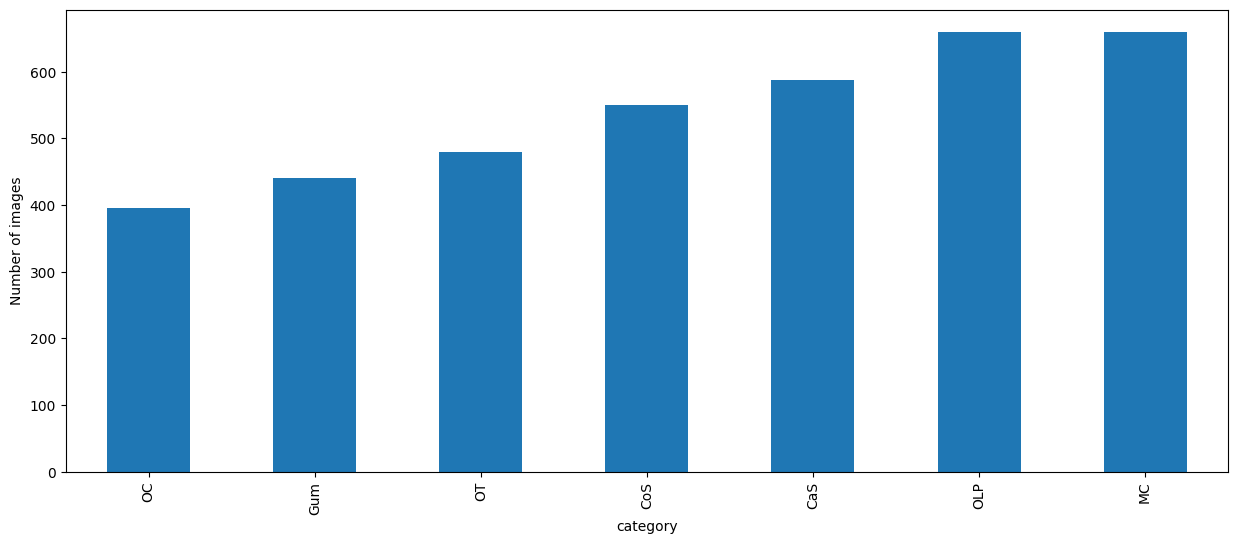

In [19]:
# create a bar plot to visualize the number of images in each folder
data_dic = {}
for folder in os.listdir(train_data):
    data_dic[folder] = len(os.listdir(train_data + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('category')
plt.ylabel('Number of images')

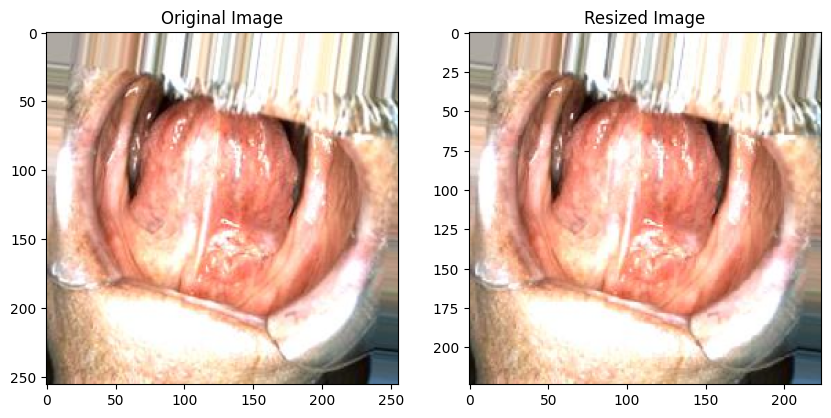

In [20]:
# prompt: ارغب برؤية صورة بعد تقليل حجم الصورة

import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

# اختر مسار صورة عشوائية من df_train
sample_image_path = df_train.sample()['path'].values[0]

# تحميل الصورة
original_image = load_img(sample_image_path)

# تقليل حجم الصورة
resized_image = load_img(sample_image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))

# عرض الصورتين
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(resized_image)
plt.title("Resized Image")

plt.show()


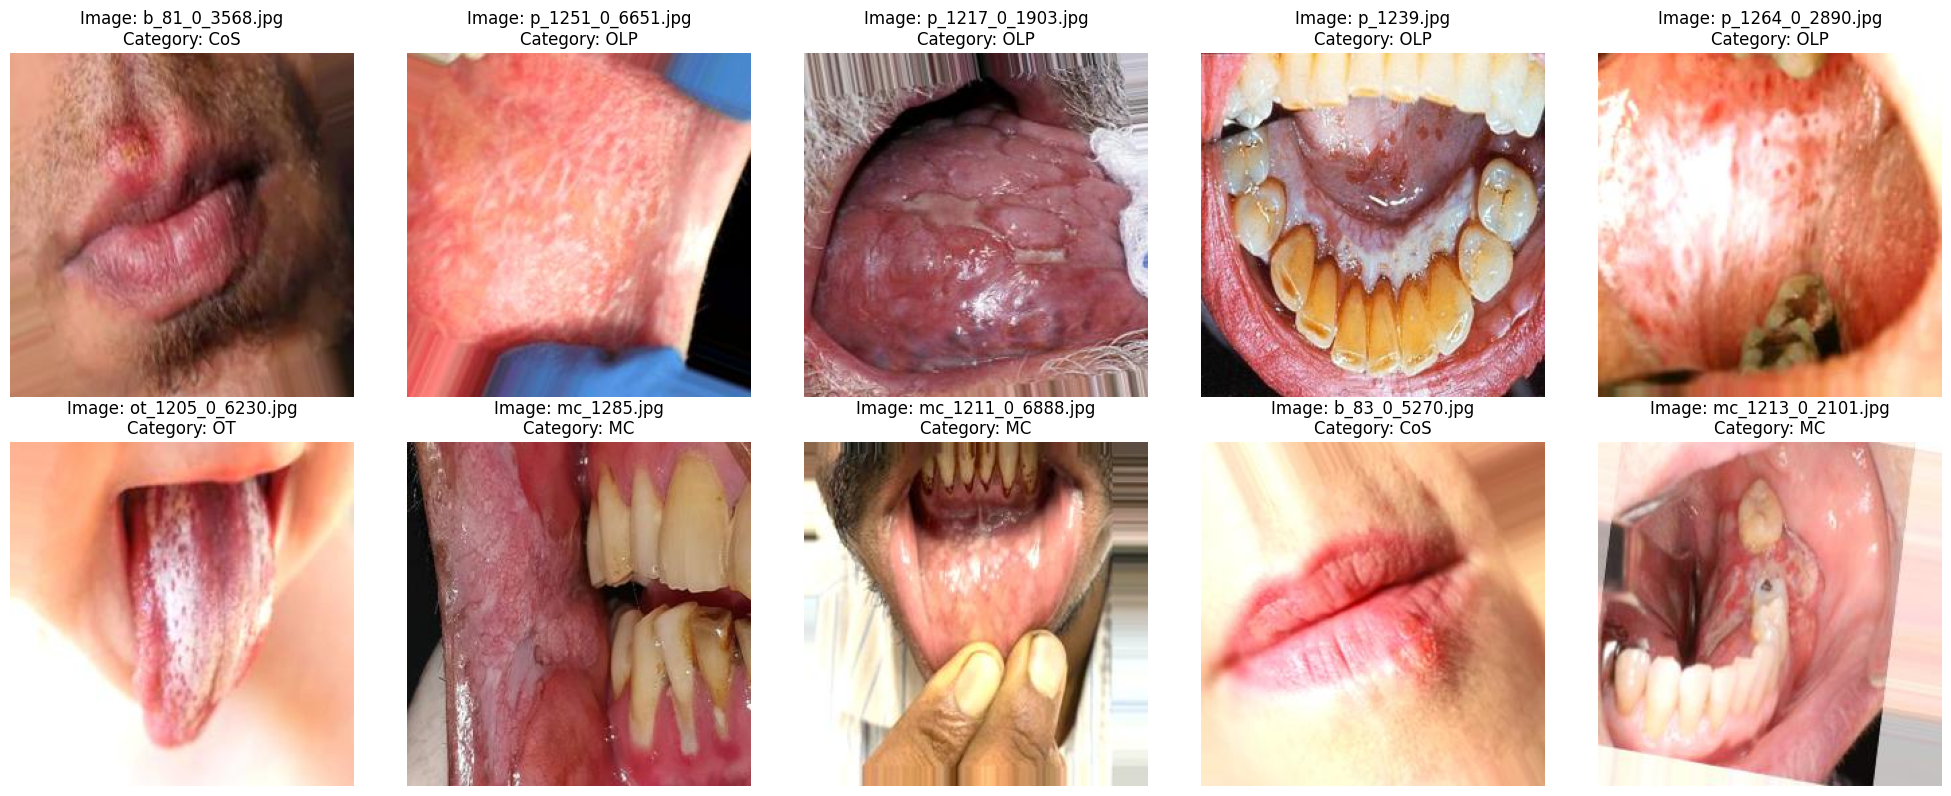

In [21]:
# Show a random collection of training file images.

def display_random_images_with_labels(df_train, class_names_label, num_images=10):

    # Randomly select images from the DataFrame
    random_images = df_train.sample(n=num_images)

    rows, cols = 2, 5  # 2 row , 5 col
    plt.figure(figsize=(20, 8))

    for i, row in enumerate(random_images.itertuples(), 1):
        img = Image.open(row.path)
        plt.subplot(rows, cols, i)
        plt.imshow(img)

        # Get name of calss from Dictionary
        category_name = [name for name, index in class_names_label.items() if index == row.category]
        category_name = category_name[0] if category_name else 'Unknown'
        plt.title(f"Image: {os.path.basename(row.path)}\nCategory: {category_name}")
        plt.axis('off')

    plt.tight_layout()  # To improve the spacing between images
    plt.show()

# Use function for display image
display_random_images_with_labels(df_train, class_names_label, num_images=10)


## Traning Generator

In [22]:
total_train = df_train.shape[0]
total_validate = df_valid.shape[0]
batch_size=32

In [23]:

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


In [24]:
# initializeing  object with various image augmentation configurations


# train_datagen = ImageDataGenerator(
#     rotation_range=15,
#     rescale=1./255,
#     shear_range=0.1,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,

# )

In [25]:

# setting up a data generator for training a model using image data from a dataframe


df_train['category'] = df_train['category'].astype(str)

train_generator = data_generator.flow_from_dataframe(
    dataframe=df_train,
    data = None,
    x_col='path',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size= batch_size
)

Found 3773 validated image filenames belonging to 7 classes.


### Display sample of image

In [26]:
# setting up  data generator to generate augmented data for single example from dataframe


example_df = df_train.sample(n=1).reset_index(drop=True)
example_generator = data_generator.flow_from_dataframe(
    dataframe=example_df,
    directory=None,  # تأكد أن المسارات كاملة في عمود 'path'
    x_col='path',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1 validated image filenames belonging to 1 classes.


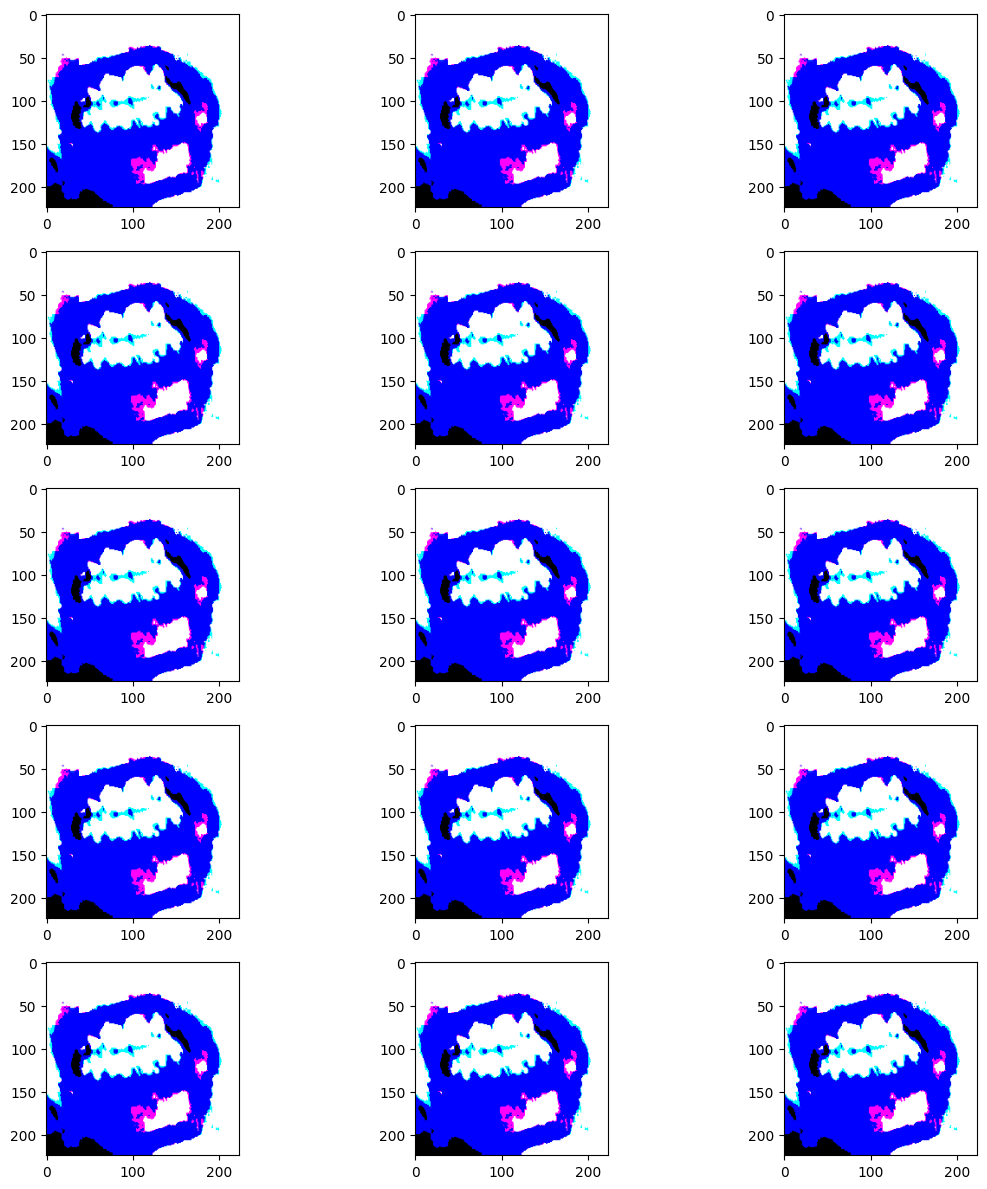

In [27]:
# generate grid of subplots to visualize augmented images
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### Validation Generator

In [28]:
# set up a data generator for validation data
df_valid['category'] = df_valid['category'].astype(str)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = data_generator.flow_from_dataframe(
    df_valid,
    data = valid_data,
    x_col='path',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size= batch_size
)

Found 685 validated image filenames belonging to 7 classes.


##Building Model

##Resnet 50

In [29]:


input_shape = (224, 224, 3)

# load ResNet-50
input_tensor = Input(shape=input_shape)
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

x = base_model.output
x = GlobalAveragePooling2D()(x)

output_tensor = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_tensor)

# freez for all resnet layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:

# model = Sequential()

# # تحديد شكل المدخلات باستخدام كائن Input
# model.add(Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS)))

# # إضافة الطبقات التلافيفية والطبقات الأخرى
# model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))


# model.add(Flatten())
# model.add(Dense(128, activation='relu'))

# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
# model.add(Dense(7, activation='softmax'))




In [ ]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()


In [ ]:


#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
#                                            patience=2,
#                                            verbose=1,
#                                            factor=0.5,
#                                            min_lr=0.00001)


In [30]:
earlystop = EarlyStopping(patience=10)

In [31]:
# save best model in drive
save_best_model = ModelCheckpoint('/content/drive/MyDrive/teeth_model/trans_teeth3.keras',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min',
                                   verbose=1)
callbacks = [earlystop, save_best_model]

In [43]:
# Assuming you have already split your data into training and validation sets and loaded them into X_train, y_train, X_val, and y_val variables


batch_size=batch_size
# Fit the model using the generators
epochs=30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,


    callbacks=callbacks
)


Epoch 1/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9990 - loss: 0.0685
Epoch 1: val_loss did not improve from 0.04616
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.9990 - loss: 0.0685 - val_accuracy: 0.9509 - val_loss: 0.1681
Epoch 2/30
  1/117 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.9688 - loss: 0.0872

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.04616
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9688 - loss: 0.0872 - val_accuracy: 1.0000 - val_loss: 0.0474
Epoch 3/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9958 - loss: 0.0590
Epoch 3: val_loss did not improve from 0.04616
117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 0.9958 - loss: 0.0590 - val_accuracy: 0.9673 - val_loss: 0.1373
Epoch 4/30
  1/117 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 1.0000 - loss: 0.0642
Epoch 4: val_loss improved from 0.04616 to 0.04185, saving model to /content/drive/MyDrive/teeth_model/trans_teeth3.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 0.0642 - val_accuracy: 1.0000 - val_loss: 0.0418
Epoch 5/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9993 - loss: 0.0499
Epoch 5: val_loss did not improve from 0.04185
117/117 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.9993 - loss: 0.0499 - val_accuracy: 0.9673 - val_loss: 0.134

## Save Model

In [ ]:
# Save Model in Google Drive
#model_save_path = '/content/drive/MyDrive/teeth_model/trans_teeth3.keras'
#
#model.save(model_save_path)
#
#print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/teeth_model/trans_teeth3.keras


In [44]:
# Load Model
model = load_model('/content/drive/MyDrive/teeth_model/trans_teeth3.keras')

## Create Testing Generator

In [45]:
# Make Data Frame with number of classes for valid folders
test_data = '/content/Teeth_NewDataset/Testing'

rows = []

for folder in os.listdir(test_data):
    path = os.path.join(test_data, folder, '*.jpg')
    image_paths = glob.glob(path)
    for image_path in image_paths:
        # احصل على التصنيف الرقمي من القاموس باستخدام اسم المجلد
        category = class_names_label.get(folder, 'unknown')  # استخدم 'unknown' إذا كان اسم المجلد غير موجود
        rows.append({'path': image_path, 'category': category})

df_test = pd.DataFrame(rows)

In [46]:
df_test['category'] = df_test['category'].astype(str)  # تحويل الفئات إلى نصوص إذا لزم الأمر


In [47]:
# set up a data generator for test data
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col='path',
    y_col='category',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 685 validated image filenames belonging to 7 classes.


In [48]:
evaluation = model.evaluate(test_generator)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.9681 - loss: 0.1206
Test Loss: 0.13576488196849823
Test Accuracy: 0.9605839252471924


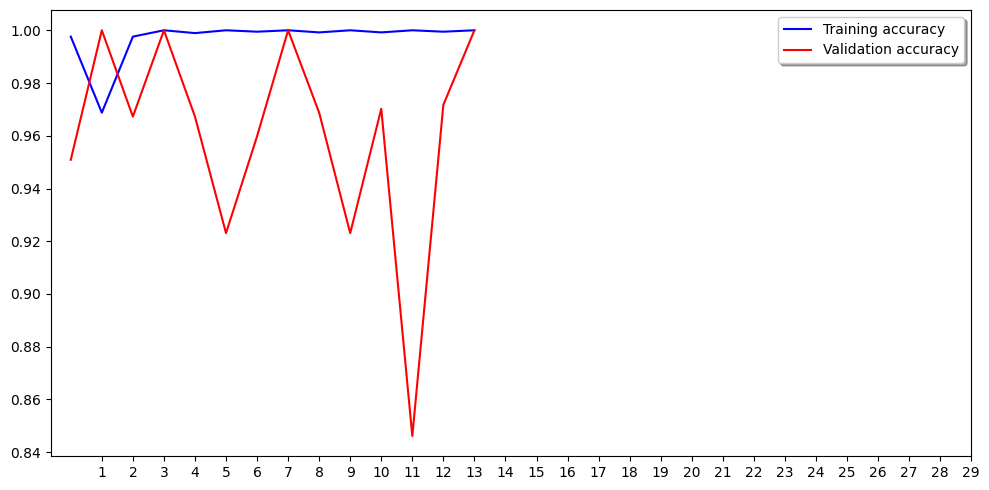

In [49]:
fig, ( ax2) = plt.subplots(1, 1, figsize=(10, 5))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [50]:
df_test


,path,category
0,/content/Teeth_NewDataset/Testing/CaS/a_152_0_...,0
1,/content/Teeth_NewDataset/Testing/CaS/a_109_0_...,0
2,/content/Teeth_NewDataset/Testing/CaS/a_92_0_8...,0
3,/content/Teeth_NewDataset/Testing/CaS/a_85_0_4...,0
4,/content/Teeth_NewDataset/Testing/CaS/a_145_0_...,0
...,...,...
680,/content/Teeth_NewDataset/Testing/CoS/b_123_0_...,6
681,/content/Teeth_NewDataset/Testing/CoS/b_95_0_1...,6
682,/content/Teeth_NewDataset/Testing/CoS/b_124_0_...,6
683,/content/Teeth_NewDataset/Testing/CoS/b_85_0_7...,6


In [51]:
df_test['label'] = df_test['path'].apply(lambda x: x.split('/')[-2])
df_test

,path,category,label
0,/content/Teeth_NewDataset/Testing/CaS/a_152_0_...,0,CaS
1,/content/Teeth_NewDataset/Testing/CaS/a_109_0_...,0,CaS
2,/content/Teeth_NewDataset/Testing/CaS/a_92_0_8...,0,CaS
3,/content/Teeth_NewDataset/Testing/CaS/a_85_0_4...,0,CaS
4,/content/Teeth_NewDataset/Testing/CaS/a_145_0_...,0,CaS
...,...,...,...
680,/content/Teeth_NewDataset/Testing/CoS/b_123_0_...,6,CoS
681,/content/Teeth_NewDataset/Testing/CoS/b_95_0_1...,6,CoS
682,/content/Teeth_NewDataset/Testing/CoS/b_124_0_...,6,CoS
683,/content/Teeth_NewDataset/Testing/CoS/b_85_0_7...,6,CoS


In [52]:
# prompt: ارجو تطبيق الكود ادناه على 7 كلاسات
# df_test['label'] = df_test['path'].apply(lambda x: x.split('/')[-2])

df_test['label'] = df_test['path'].apply(lambda x: x.split('/')[-2])


## drawing confusion matrix

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


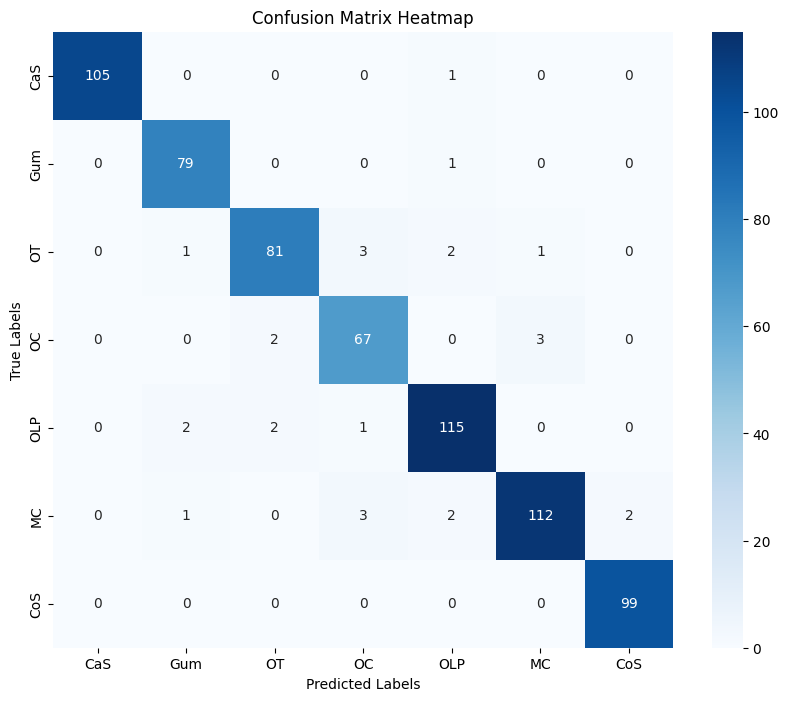

In [53]:

nb_samples = test_generator.n

predict = model.predict(test_generator, steps=int(np.ceil(nb_samples/16)))

# تحويل التوقعات إلى الفئات المتوقعة
predicted_classes = np.argmax(predict, axis=1)

# الحصول على الفئات الحقيقية من مولد البيانات
true_classes = test_generator.classes

conf_matrix = confusion_matrix(true_classes, predicted_classes)

# إعداد أسماء الفئات
class_names = list(class_names_label.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [55]:
# Import Libraries
from sklearn.metrics import classification_report
#----------------------------------------------------

#----------------------------------------------------
#Calculating classification Report :
#classification_report(y_true, y_pred, labels=None, target_names=None,sample_weight=None, digits=2, output_dict=False)

# ClassificationReport = classification_report(y_test,y_pred)
#print('Classification Report is : ', ClassificationReport )

In [56]:
# prompt:  y_test,y_pred من الاكواد السابقة كيف اعطي

import numpy as np
# الحصول على الفئات الحقيقية من مولد البيانات
y_test = test_generator.classes

# الحصول على تنبؤات النموذج
y_pred_probs = model.predict(test_generator)

# تحويل تنبؤات الاحتمالات إلى تنبؤات فئات
y_pred = np.argmax(y_pred_probs, axis=1)

# طباعة تقرير التصنيف
print(classification_report(y_test, y_pred, target_names=class_names))


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step
              precision    recall  f1-score   support

         CaS       1.00      0.99      1.00       106
         Gum       0.95      0.99      0.97        80
          OT       0.95      0.92      0.94        88
          OC       0.91      0.93      0.92        72
         OLP       0.95      0.96      0.95       120
          MC       0.97      0.93      0.95       120
         CoS       0.98      1.00      0.99        99

    accuracy                           0.96       685
   macro avg       0.96      0.96      0.96       685
weighted avg       0.96      0.96      0.96       685

